# Домашнее задание 5. Градиентный спуск. (10 баллов + 2.5 бонус)

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

In [2]:
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [3]:
import abc


class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

**Задание 1.1 (5/8 балла):** Реализуйте класс `MSELoss`

Он должен вычислять лосс и градиент по формулам наверху

In [4]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        y_pred = [np.sum(i * w) for i in X]
        return ((y - y_pred) ** 2).mean()

        # Вычислите значение функции потерь при помощи X, y и w и верните его

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return 2 * np.dot(X.T, np.dot(X, w) - y) / y.shape[0]



        # Вычислите значение вектора градиента при помощи X, y и w и верните его

Теперь мы можем создать объект `MSELoss` и при помощи него вычислять значение нашей функции потерь и градиенты:

In [5]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

**Задание 1.2 (5/8 балла):** Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [6]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 10000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init.copy()
    w_list = [w]
    for i in range(n_iterations):
      w -=  lr * loss.calc_grad(X, y, w)
      w_list.append(w.copy())
    return w_list

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [ ]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [ ]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

0.8670644395649494
0.8670644395649494


In [7]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(
        A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

**Задание 1.3 (5/8 балла):** При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

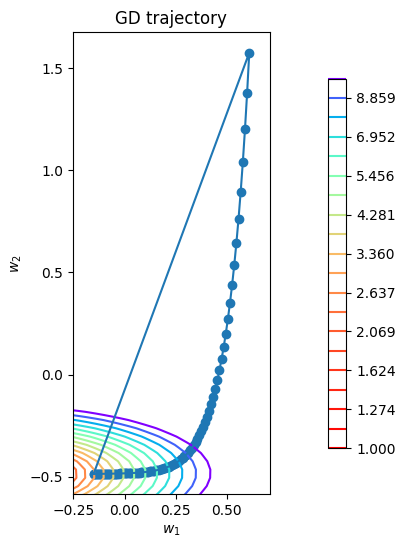

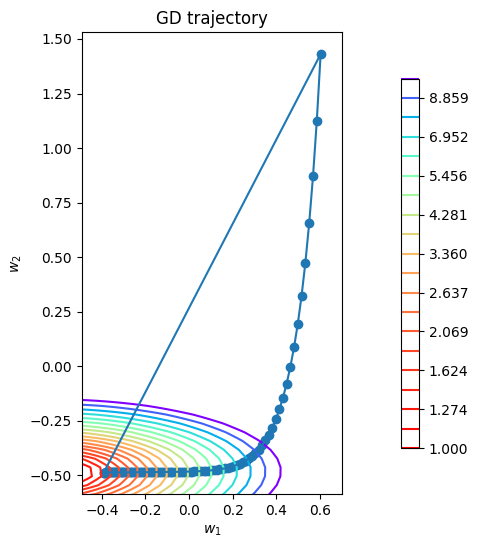

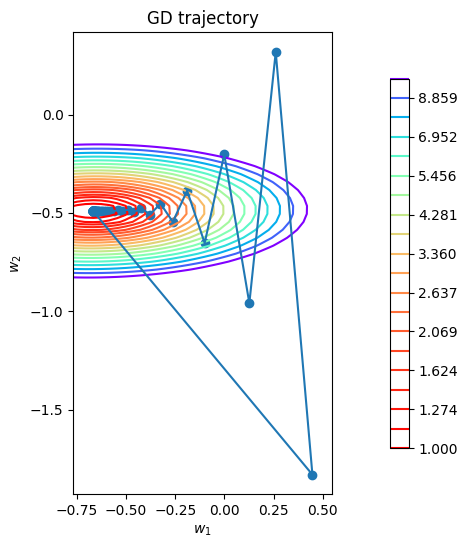

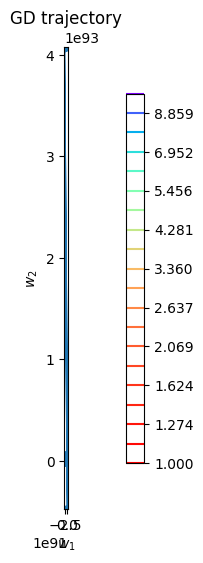

In [ ]:
lr_list = [0.0006,0.001, 0.01, 0.06]
for lr in lr_list:
  w_list = gradient_descent(w_init, X, y, loss, lr, 100)
  plot_gd(w_list, X, y, loss)

lr - длина шага, которая позволяет контролировать скорость подхождения к минимуму, чем больше шаг, тем быстрее модель меняет веса в сторону локального минимума, однако с этим же повышается вероятность расхождения градиентного спуска.
Так например, при lr = 0.0006,0.001 ГС просто не успевает доходить до минимума за 100 итераций и он очень равномерный; при lr = 0.01 он уже начинает сильно скакать между значениями и доходит до минимума, а при lr = 0.06 он уже расходится, так как перескакивает локальный минимум (сильно длинный шаг)

Теперь реализуем стохастический градиентный спуск

**Задание 1.4 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [8]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    w = w_init.copy()
    w_list = [w]
    for i in range(n_iterations):
      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      batch = X[batch_indices]
      w -=  lr * loss.calc_grad(batch, y[batch_indices], w)
      w_list.append(w.copy())
    return w_list
    

**Задание 1.5 (5/8 балла):** При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

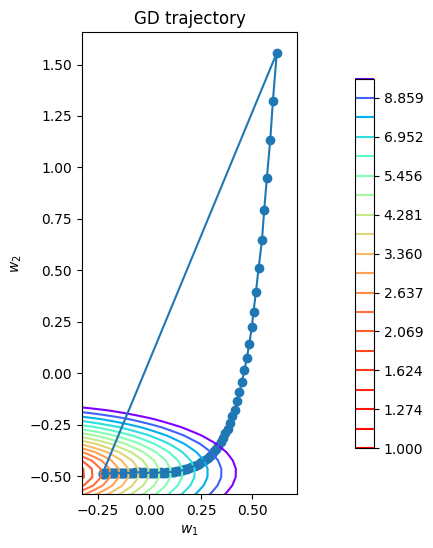

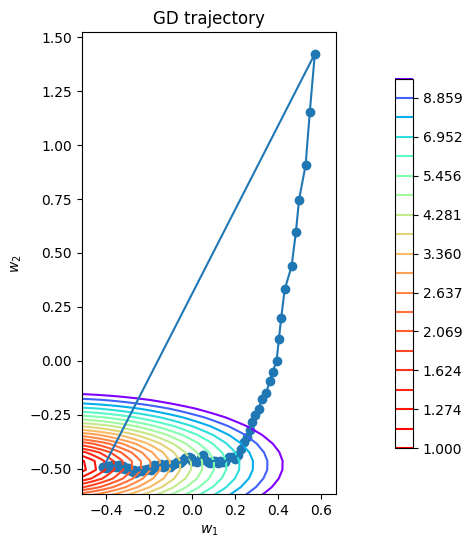

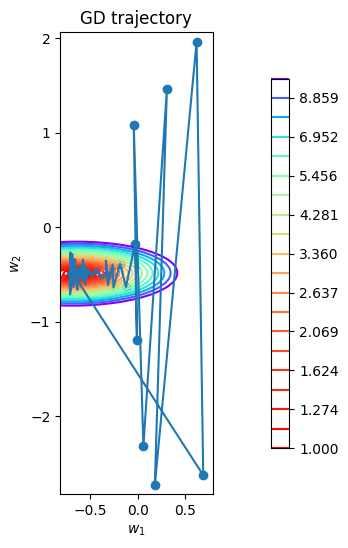

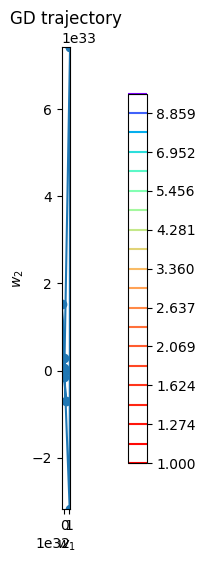

In [ ]:
lr_list = [0.0007,0.001, 0.01, 0.02]
batch_size_list = [200, 20, 15, 150]
for lr, batch_size in zip(lr_list, batch_size_list):
  w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, 100)
  plot_gd(w_list, X, y, loss)

Опять же сразу видно, что при относительно болшом lr, СГС расходится в независимости от batch_size. При сильно малых lr СГС не доходит до минимума. На рисунке 1 - 3 хорошо видно, как влияет batch_size на СГС: при большом batch_size СГС почти никак не отличается от ГС, что в целом логично, ведь размер выборки похож на размер всех данных при ГС. Чем меньше размер выборки,тем более скачкообразно (неравномерно и непостепенно) меняются значения весов.  

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага. 

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его. 

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

**Задание 1.6 (5/8 балла):** Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [9]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    
    
    w = w_init.copy()
    w_list = [w]
    for i in range(n_iterations):
      batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
      batch = X[batch_indices]
      w -=  lr * (1 / (1 + i)) ** p * loss.calc_grad(batch, y[batch_indices], w)
      w_list.append(w.copy())
    return w_list

**Задание 1.7 (5/8 балла):** При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

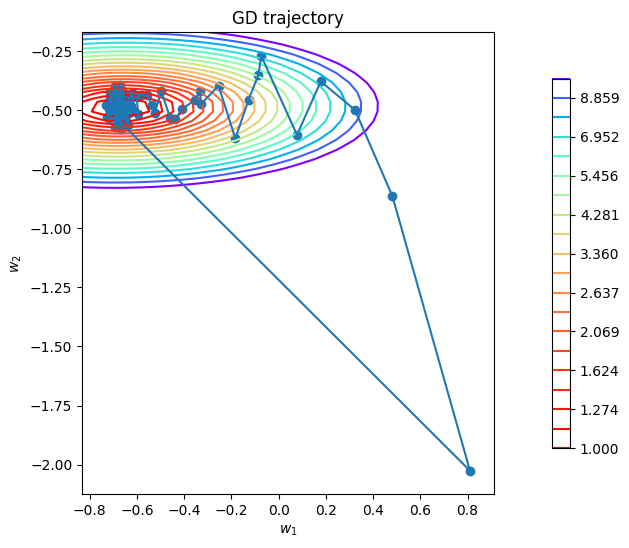

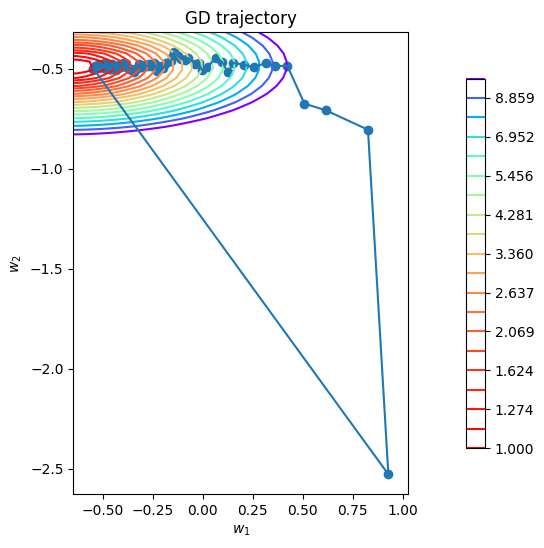

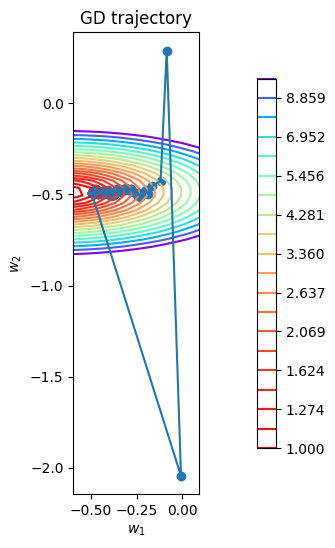

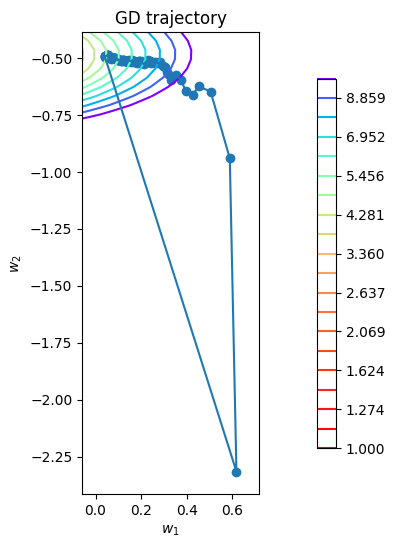

In [ ]:
p_list = [0.1, 0.56, 0.75, 0.99]
for p in p_list:
  w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, p, 100)
  plot_gd(w_list, X, y, loss)


В формуле длины шага числитель меньше, чем знаменатель, соответственно при возведении этой дроби в степень, результат возведения становится меньше. Тогда при большой степени, длина шага становится очень маленькой. И градиентный спуск просто не успевает дойти до экстремума. Что видно на рисунке 2 - 4.

**Задание 1.8 (5/8 балла):** Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

In [ ]:
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)


In [ ]:
w_list2 = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 0.1, 100)


In [ ]:
loss2 = MSELoss()
losses1 = []
losses2 = []
for weight1, weight2 in zip(w_list, w_list2):
  losses1.append(loss2.calc_loss(X, y, weight1))
  losses2.append(loss2.calc_loss(X, y, weight2))

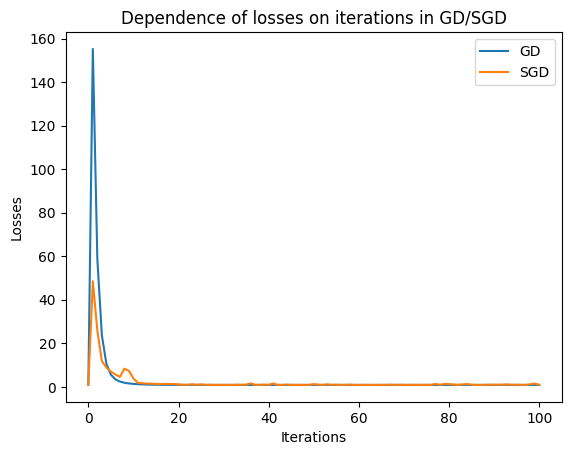

In [ ]:
plt.plot(losses1)
plt.plot(losses2)
plt.title('Dependence of losses on iterations in GD/SGD')
plt.xlabel('Iterations')
plt.ylabel('Losses')
plt.legend(['GD','SGD'])
plt.show()

Преимущество SGD видно, гораздо меньше ошибки при начальных итерациях, так как выборка небольшая, это как минимум экономит память и время

## Часть 2. Линейная регрессия (5 баллов)

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

**Задание 2.1 (5/8 балла):** Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [10]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
        self.w = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        w0 = np.random.normal(-2, 2, X.shape[1])

        w_list = gradient_descent(w0, X, y, self.loss, self.lr)
        self.w = w_list[len(w_list) - 1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])

        y_pred = [np.sum(i * self.w) for i in X]
        return y_pred

        

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [ ]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [11]:
import pandas as pd

X_raw = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)


**Задание 2.2 (5/8 балла):** Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [12]:
# создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values

# для вещественнозначных признаков заполним пропуски средними
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(
    data=mis_replacer.fit_transform(X_real), columns=X_real.columns
)

# для категориальных — пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

In [13]:
y = X_no_mis[25]
X_raw = X_no_mis.drop(25, axis=1)
X_dum = pd.get_dummies(X_raw, drop_first=True)

In [14]:
normalizer = MinMaxScaler()
X_dum.columns = X_dum.columns.astype(str)
X_real_norm_np = normalizer.fit_transform(X_dum)
X = pd.DataFrame(data=X_real_norm_np)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

**Задание 2.3 (5/8 балла):** Обучите написанную вами линейную регрессию на обучающей выборке

In [ ]:
linear_regression = linear_regression.fit(X_train, y_train)

**Задание 2.4 (5/8 балла):** Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода `mean_squared_error` из `sklearn.metrics`.

In [ ]:
from sklearn.metrics import mean_squared_error as mse

mse(y_train, linear_regression.predict(X_train)), mse(y_test, linear_regression.predict(X_test))

(1826448.8995137142, 8126882.576601223)

Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

**Задание 2.5 (5/8 балла):** Реализуйте класс `MSEL2Loss`

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [ ]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        
        y_pred = [np.sum(i * w) for i in X]
        return ((y - y_pred) ** 2).mean() + (self.coef * w[:w.shape[0] - 1] ** 2).mean()
        # Вычислите значение функции потерь при помощи X, y и w и верните его

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        w[w.shape[0] - 1] = 0
        return 2 * np.dot(X.T, np.dot(X, w) - y) / y.shape[0] + 2 * self.coef * w

        # Вычислите значение вектора градиента при помощи X, y и w и верните его

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [ ]:
linear_regression = LinearRegression(MSEL2Loss(0.0005))

**Задание 2.6 (5/8 балла):** Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации. 

In [ ]:
linear_regression = linear_regression.fit(X_train, y_train)

In [ ]:
mse(y_train, linear_regression.predict(X_train)), mse(y_test, linear_regression.predict(X_test))

(2148167.6087740697, 6386979.077342796)

Теперь mse на тренировочной стал больше примерно на 1 миллион, а на тестовой стал гораздо меньше (на 2 миллиона), регуляризация сработала.

В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

**Задание 2.7 (5/8 балла):** Реализуйте класс `HuberLoss`

Он должен вычислять лосс и градиент по формулам наверху

In [ ]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        y_pred = [np.sum(i * w) for i in X]
        z = y - y_pred
        bools = np.abs(z) < self.eps
        not_bools = np.abs(z) >= self.eps

        answers = (0.5 * z ** 2) * bools + not_bools * (self.eps * (np.abs(z) - 0.5 * self.eps))

        return answers.mean()

        # Вычислите значение функции потерь при помощи X, y и w и верните его

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        y_pred = [np.sum(i * w) for i in X]
        z = y - y_pred

        bools = np.abs(z) < self.eps
        not_bools = np.abs(z) >= self.eps

        z = z * bools + (self.eps * np.sign(z)) * not_bools

        answers = X.T @ z

        return answers / y.shape[0]


        # Вычислите значение вектора градиента при помощи X, y и w и верните его

**Задание 2.8 (5/8 балла):** Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [ ]:
linear_regression = LinearRegression(HuberLoss(0.0001324))

In [ ]:
linear_regression = linear_regression.fit(X_train, y_train)

In [ ]:
mse(y_train, linear_regression.predict(X_train)), mse(y_test, linear_regression.predict(X_test))

(221503940.32790053, 298061217.1868135)

HuberLoss получился гораздо больше чем MSE, скорее всего у меня не получилось подобрать хороший параметр и из-за этого результат не стал лучше.

**Задание 3 (0.08/8 балла)**
Вставьте ваш любимый мем 2021 в ячейку ниже:

Улитка заходит в бар, но бармен заявляет: "У нас строгая политика в отношении улиток!" — и ногой выпихивает ее на улицу. Через неделю улитка возвращается в бар и говорит бармену: "Ну и нах ты это сделал!?"

### БОНУС (2.5 баллов)

Градиентный спуск — далеко не единственный метод оптимизации. 
Другой очень известный метод называется ["Алгоритм имитации отжига"](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B8%D0%BC%D0%B8%D1%82%D0%B0%D1%86%D0%B8%D0%B8_%D0%BE%D1%82%D0%B6%D0%B8%D0%B3%D0%B0). Он не так часто используется для оптимизации моделей машинного обучения, но у вас есть уникальная возможность попробовать применить его к нашей любимой линейной регрессии.

**Задание (2.5 баллов)**:
Напишите алгоритм имитации отжига для оптимизации MSE линейной регрессии. 

Сравните результат с градиентным спуском по "траектории" и по финальному лоссу.

Подсказка: каждую новую точку (веса регресси в нашем случае) можно семплировать из некоторого случайного распределением с центром в текущей точке. Хорошо подойдут распределения с "тяжёлыми" хвостами, например, распределение Стьюдента с параметром количества степеней свободы в районе 3.
Это может выглядеть, например, так:
```
new_w = old_w + np.random.standard_t(3, size=old_w.shape)
```
С параметром распределения можно поэксперементировать: чем он больше, тем реже новые точки будут очень сильно уходить от старых.

In [30]:
def annealing (
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    n_iterations: int = 100000,
) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    old_w = w_init.copy()
    w_list = [old_w]
    new_w = old_w
    for i in range(n_iterations):
      new_w = old_w + np.random.standard_t(3, size=old_w.shape)
      if loss.calc_loss(X, y.T, new_w) >= loss.calc_loss(X, y.T, old_w):
        new_w = old_w
      else:
        break
      old_w = new_w
      w_list.append(old_w.copy())
    return w_list

In [22]:
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)
lossA = MSELoss()
X.shape, y.shape, w.shape
lossA.calc_loss(X, y, w)

27410283.5

In [29]:
w0 = np.random.normal(-2, 2, X_train.shape[1])
new_w = w0 + np.random.standard_t(3, size=w0.shape)

w = annealing(w0, X_train, y_train, lossA)

#plot_gd(w, X_train, y_train, lossA)



ValueError: ignored